In [159]:
import pandas as pd

df = pd.read_csv('data/seniority-level.csv')

In [160]:
df.dropna(axis=0, inplace=True)

In [161]:
df.head()

,jobtitle,link,summary,description,Seniority
0,Einkäufer (w/m/d),https://www.roberthalf.de/job/munchen/einkaufe...,Einkäufer (w/m/d) gesucht - Für unseren Kunden...,"<div class=""rh-job-page__job-info-text""><p><st...",Medior
1,Bilanzbuchhalter (w/m/d),https://www.roberthalf.de/job/essen/bilanzbuch...,Bilanzbuchhalter (w/m/d) gesucht - Für unseren...,"<div class=""rh-job-page__job-info-text""><p><st...",Senior
2,Bilanzbuchhalter (w/m/d),https://www.roberthalf.de/job/duisburg/bilanzb...,Bilanzbuchhalter (w/m/d) gesucht - Für unseren...,"<div class=""rh-job-page__job-info-text""><p><st...",Senior
3,Finanzbuchhalter (w/m/d),https://www.roberthalf.de/job/unna/finanzbuchh...,Finanzbuchhalter (w/m/d) gesucht - Für unseren...,"<div class=""rh-job-page__job-info-text""><p><st...",Medior
4,Sachbearbeiter Logistik (w/m/d),https://www.roberthalf.de/job/worms/sachbearbe...,Sachbearbeiter Logistik (w/m/d) gesucht - Für ...,"<div class=""rh-job-page__job-info-text""><p><st...",Junior


In [162]:
df.shape

(140, 5)

In [196]:
df_jf = pd.read_csv('data/seniority-level-jf.csv')

In [197]:
df_jf.dropna(axis=0, inplace=True)

In [198]:
df_jf.head()

,filename,derived_vac_title,derived_vac_job_title,derived_profession_final,fulltext,Seniority
0,file:/home/dehling/Downloads/jf_data_de/jf_dat...,Praktikant IT-Entwicklung - Projekt Industrie ...,Praktikant IT-Entwicklung - Projekt Industrie ...,praktikant,Praktikant IT-Entwicklung - Projekt Industrie ...,Junior
1,file:/home/dehling/Downloads/jf_data_de/jf_dat...,Assistenzärzte (m/w) für ein Ausbildungscurric...,Assistenzärzte (m/w) für ein Ausbildungscurric...,assistenzärzte ausbildungscurriculum innere me...,assistenzärzte (m/w) für ein ausbildungscurric...,Medior
2,file:/home/dehling/Downloads/jf_data_de/jf_dat...,Koch (m/w),Koch (m/w),koch,Das Sylter Stadtgeflüster ist eine Genussoase ...,Medior
3,file:/home/dehling/Downloads/jf_data_de/jf_dat...,"Fachinformatiker/in, Systemintegration","Fachinformatiker/in, Systemintegration",fachinformatiker systemintegration,"Fachinformatiker/in, Systemintegration ?% Eign...",Junior
4,file:/home/dehling/Downloads/jf_data_de/jf_dat...,Praktikum im Spezialtiefbau - Bauingenieurwesen,Praktikum im Spezialtiefbau - Bauingenieurwesen,praktikum,Praktikum im Spezialtiefbau - Bauingenieurwese...,Junior


In [199]:
df_jf.shape

(101, 6)

In [200]:
from gensim.parsing.preprocessing import preprocess_string, RE_TAGS, strip_punctuation, \
    strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short, stem_text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler


def my_remove_tags(s):
    return RE_TAGS.sub(" ", s)

my_filters = [
    lambda x: x.lower(), my_remove_tags, strip_punctuation,
    strip_multiple_whitespaces, strip_numeric,
    remove_stopwords, strip_short, stem_text
]

def my_tokenizer(s):
    return preprocess_string(s, my_filters)
    
vect = CountVectorizer(min_df=8, max_df=0.33, strip_accents='unicode', analyzer='word',
                       tokenizer=my_tokenizer, ngram_range=(1,2))

le = LabelEncoder()

X = vect.fit_transform(df['description'].tolist() + df_jf['fulltext'].tolist())
y = le.fit_transform(df['Seniority'].tolist() + df_jf['Seniority'].tolist())

#scaler = MaxAbsScaler()
#X_scaled = scaler.fit_transform(X)

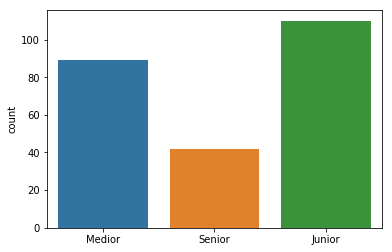

In [201]:
import seaborn as sns
%matplotlib inline

ax = sns.countplot(x=(df['Seniority'].tolist() + df_jf['Seniority'].tolist()))

In [202]:
X.shape

(241, 847)

In [233]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()

scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='accuracy')
print("Accuracy: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='f1_macro')
print("F1: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='neg_log_loss')
print("Log loss: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

Accuracy: 0.5233 (+/- 0.0798)
F1: 0.5031 (+/- 0.1098)
Log loss: -4.7871 (+/- 1.5038)


In [234]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs', multi_class='auto')

scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='accuracy')
print("Accuracy: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='f1_macro')
print("F1: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='neg_log_loss')
print("Log loss: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

Accuracy: 0.6065 (+/- 0.0673)
F1: 0.5007 (+/- 0.1041)
Log loss: -1.1492 (+/- 0.2554)


In [235]:
from sklearn.svm import SVC, LinearSVC

#clf = LinearSVC()
clf = SVC(kernel='linear', probability=True)


scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='accuracy')
print("Accuracy: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='f1_macro')
print("F1: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='neg_log_loss')
print("Log loss: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

Accuracy: 0.5727 (+/- 0.0820)
F1: 0.5203 (+/- 0.0605)
Log loss: -0.9036 (+/- 0.0203)


In [224]:
from sklearn.model_selection import train_test_split

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y)

#clf = MultinomialNB()
clf = LogisticRegression(solver='sag', multi_class='auto')
#clf = LinearSVC()
clf.fit(Xtr, ytr)

/home/dehling/Documents/machine-learnings/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [221]:
Xtr.shape

(192, 847)

In [222]:
Xte.shape

(49, 847)

In [225]:
from sklearn.metrics import classification_report

ypred = clf.predict(Xte)

print(classification_report(yte, ypred, target_names=le.classes_))

              precision    recall  f1-score   support

      Junior       0.70      0.73      0.71        22
      Medior       0.57      0.67      0.62        18
      Senior       0.60      0.33      0.43         9

   micro avg       0.63      0.63      0.63        49
   macro avg       0.62      0.58      0.59        49
weighted avg       0.63      0.63      0.62        49



In [185]:
le.classes_

array(['Junior', 'Medior', 'Senior'], dtype='<U6')

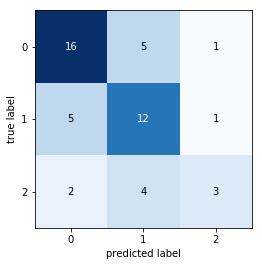

In [226]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(confusion_matrix(yte, ypred))

In [227]:
import numpy as np

feature_names = vect.get_feature_names()
for i, class_label in enumerate(le.classes_):
    top10 = np.argsort(clf.coef_[i])[-20:]
    print("%s: %s" % (class_label, ", ".join(feature_names[j] for j in top10)))
    print()

Junior: korrespondenz, pflege, umgang, herr, arbeiten, einarbeitung, lohn, rollout, such, anwendungen, ihnen herr, zuverlassig, student, dein, moglich, umgang mit, bewerbung, recruit, erst berufserfahrung, erst

Medior: deutschland, durchfuhrung, unternehmen mit, teamfahigkeit, ist ein, market, der buchhaltung, einer, profil erfolgreich, team, raum, fuhrerschein, produkt, berlin, bearbeitung, administr, stuttgart, wunschenswert, wir suchen, gmbh

Senior: posit, anderen, fundiert, buchhaltung, rechnungen, al mitarbeit, eigenstandig, develop, mehrjahrig berufserfahrung, art, softwar, dies, vorbereitung, account, nach hgb, mehrjahrig, durch, hgb, einschlagig, control

